In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
WINDOW_SIZE = 10  # You can change this to 2, 5, 20, etc.
# ---------------------

def generate_true_recursive_sine(length=800):
    omega = 0.15
    coeff = 2 * np.cos(omega)

    # Start sequence around 0.5 center
    seq = [0.5, 0.55]

    for _ in range(length - 2):
        # The recursive rule: centered at 0.5
        next_val = coeff * (seq[-1] - 0.5) - (seq[-2] - 0.5) + 0.5
        # Clamp to your 0.25 - 0.75 requirement
        next_val = np.clip(next_val, 0.2501, 0.7499)
        seq.append(next_val)

    return np.array(seq, dtype=np.float32)

full_data = generate_true_recursive_sine(800)

def create_dataset(data, k):
    X, y = [], []
    for i in range(len(data) - k):
        X.append(data[i : i + k])
        y.append(data[i + k])
    return torch.tensor(np.array(X)), torch.tensor(np.array(y)).view(-1, 1)

X_train, y_train = create_dataset(full_data[:600], WINDOW_SIZE)
print(f"Window Size: {WINDOW_SIZE}")
print(f"X_train shape: {X_train.shape}")

Window Size: 10
X_train shape: torch.Size([590, 10])


In [9]:
class VariableRecursiveNet(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(k, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = VariableRecursiveNet(WINDOW_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 0.3593261242
Epoch 200, Loss: 0.0000273427
Epoch 400, Loss: 0.0000263123
Epoch 600, Loss: 0.0000250990
Epoch 800, Loss: 0.0000237911


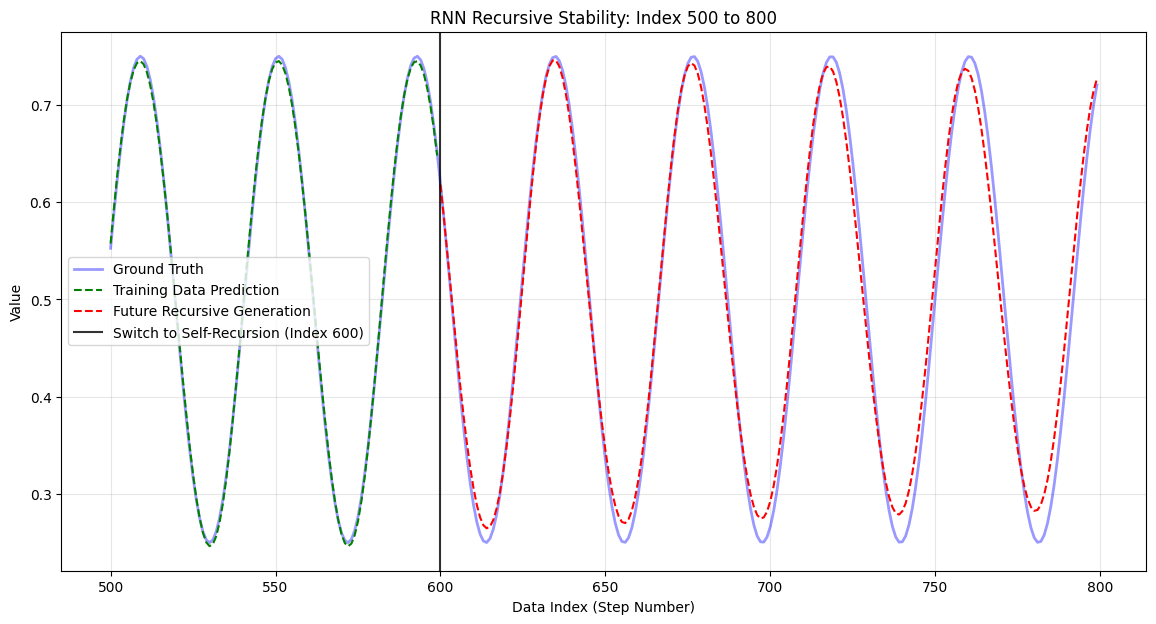

In [11]:
# --- STEP 1: PREDICT LAST 100 OF TRAINING (Indices 500-600) ---
train_preds = []
model.eval()
with torch.no_grad():
    # We use the windows corresponding to indices 500 to 599
    # This predicts the values for indices 510 to 600
    for i in range(500 - WINDOW_SIZE, 600 - WINDOW_SIZE):
        input_window = X_train[i].unsqueeze(0)
        pred = model(input_window).item()
        train_preds.append(pred)

# --- STEP 2: PREDICT 200 OF TEST DATA (Indices 600-800) ---
# Initialize current_window as a 2D tensor (batch_size, WINDOW_SIZE)
current_window = full_data[600-WINDOW_SIZE:600].reshape(1, WINDOW_SIZE)
future_preds = []
with torch.no_grad():
    for _ in range(200):
        # Ensure input_tensor is 2D (1, WINDOW_SIZE)
        input_tensor = torch.tensor(current_window, dtype=torch.float32)
        next_val = model(input_tensor).item()
        future_preds.append(next_val)

        # SLIDING WINDOW: Use own prediction for the next step
        # new_val_tensor should be (1, 1) for concatenation
        new_val_tensor = np.array([[next_val]], dtype=np.float32)
        current_window = np.concatenate((current_window[:, 1:], new_val_tensor), axis=1)

# --- STEP 3: PLOTTING WITH ACTUAL INDICES ---
# Ground truth for the full range from 500 to 800
ground_truth = full_data[500:800]

plt.figure(figsize=(14, 7))

# Plot Ground Truth (Indices 500 to 800)
plt.plot(np.arange(500, 800), ground_truth, label='Ground Truth', color='blue', lw=2, alpha=0.4)

# Plot Training Predictions (Indices 500 to 600)
plt.plot(np.arange(500, 600), train_preds, label='Training Data Prediction', color='green', ls='--')

# Plot Future Recursion (Indices 600 to 800)
plt.plot(np.arange(600, 800), future_preds, label='Future Recursive Generation', color='red', ls='--')

# Switch point marker at exactly index 600
plt.axvline(x=600, color='black', alpha=0.8, label='Switch to Self-Recursion (Index 600)')

plt.title("RNN Recursive Stability: Index 500 to 800")
plt.xlabel("Data Index (Step Number)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
WINDOW_SIZE = 5

X_train, y_train = create_dataset(full_data[:600], WINDOW_SIZE)
print(f"Window Size: {WINDOW_SIZE}")
print(f"X_train shape: {X_train.shape}")

Window Size: 5
X_train shape: torch.Size([595, 5])


In [13]:
model = VariableRecursiveNet(WINDOW_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 0.3072839379
Epoch 200, Loss: 0.0017601843
Epoch 400, Loss: 0.0000439302
Epoch 600, Loss: 0.0000369619
Epoch 800, Loss: 0.0000309227


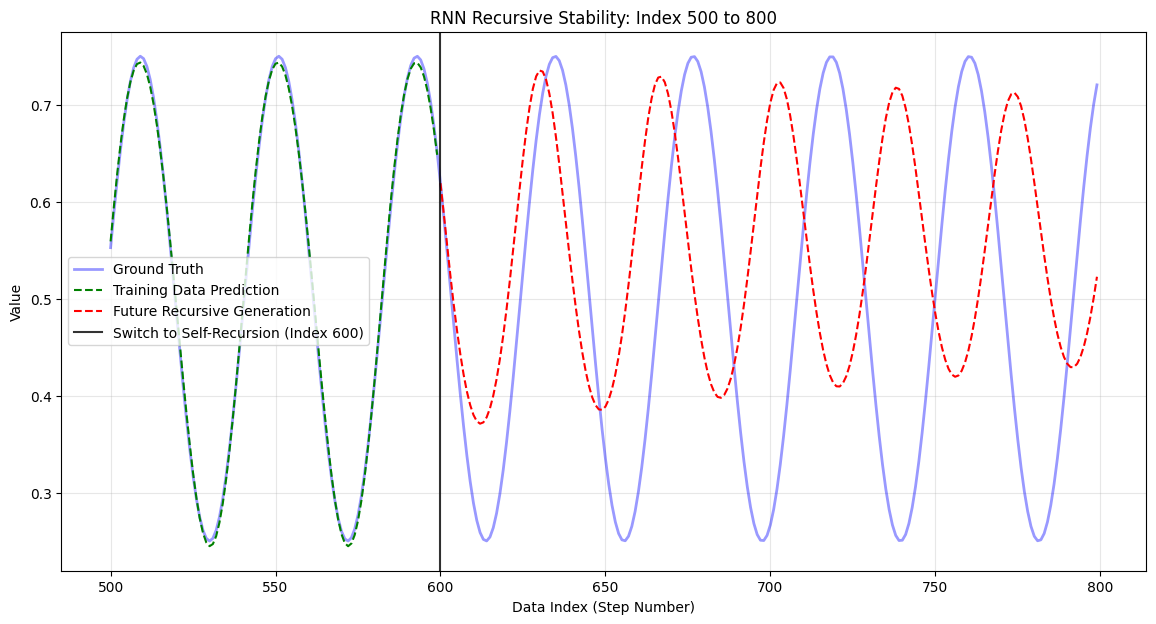

In [14]:
# --- STEP 1: PREDICT LAST 100 OF TRAINING (Indices 500-600) ---
train_preds = []
model.eval()
with torch.no_grad():
    # We use the windows corresponding to indices 500 to 599
    # This predicts the values for indices 510 to 600
    for i in range(500 - WINDOW_SIZE, 600 - WINDOW_SIZE):
        input_window = X_train[i].unsqueeze(0)
        pred = model(input_window).item()
        train_preds.append(pred)

# --- STEP 2: PREDICT 200 OF TEST DATA (Indices 600-800) ---
# Initialize current_window as a 2D tensor (batch_size, WINDOW_SIZE)
current_window = full_data[600-WINDOW_SIZE:600].reshape(1, WINDOW_SIZE)
future_preds = []
with torch.no_grad():
    for _ in range(200):
        # Ensure input_tensor is 2D (1, WINDOW_SIZE)
        input_tensor = torch.tensor(current_window, dtype=torch.float32)
        next_val = model(input_tensor).item()
        future_preds.append(next_val)

        # SLIDING WINDOW: Use own prediction for the next step
        # new_val_tensor should be (1, 1) for concatenation
        new_val_tensor = np.array([[next_val]], dtype=np.float32)
        current_window = np.concatenate((current_window[:, 1:], new_val_tensor), axis=1)

# --- STEP 3: PLOTTING WITH ACTUAL INDICES ---
# Ground truth for the full range from 500 to 800
ground_truth = full_data[500:800]

plt.figure(figsize=(14, 7))

# Plot Ground Truth (Indices 500 to 800)
plt.plot(np.arange(500, 800), ground_truth, label='Ground Truth', color='blue', lw=2, alpha=0.4)

# Plot Training Predictions (Indices 500 to 600)
plt.plot(np.arange(500, 600), train_preds, label='Training Data Prediction', color='green', ls='--')

# Plot Future Recursion (Indices 600 to 800)
plt.plot(np.arange(600, 800), future_preds, label='Future Recursive Generation', color='red', ls='--')

# Switch point marker at exactly index 600
plt.axvline(x=600, color='black', alpha=0.8, label='Switch to Self-Recursion (Index 600)')

plt.title("RNN Recursive Stability: Index 500 to 800")
plt.xlabel("Data Index (Step Number)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()